<div style="text-align: left">
    <img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/logo.png?raw=true' width=800/>  
</div>

Author: Itay Segev

E-mail: [itaysegev@campus.technion.ac.il](mailto:itaysegev@campus.technion.ac.il)



# Policy Gradient


<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/tut04_creation_of_ai.png?raw=true' width=900/>


<a id="section:intro"></a>

# <img src="https://img.icons8.com/?size=50&id=55412&format=png&color=000000" style="height:50px;display:inline"> Introduction
---

In reinforcement learning, **policy gradient methods** are a class of algorithms that directly optimize the policy, denoted as $\pi_{\theta}(a|s)$ , which maps states $s$ to a probability distribution over actions $a$. The primary objective of these methods is to maximize the expected return, $J(\pi_{\theta})$, which represents the cumulative reward an agent receives over time.

Policy gradient methods achieve this by performing gradient ascent on the expected return. This involves adjusting the policy parameters, $\theta\$, in the direction that increases the expected return. By iteratively following the gradient of the expected return, the policy parameters are updated to improve the agent's performance.

These methods are particularly useful for environments with continuous action spaces and for learning stochastic policies, which are essential for handling uncertainty and exploration. The direct optimization of the policy often leads to more stable and efficient learning processes, making policy gradient methods powerful tools for solving complex reinforcement learning problems.

In this tutorial, we will cover the basics of policy gradient methods, which are a foundational class of algorithms in reinforcement learning. We will walk through the core concepts and provide detailed explanations to help you understand how policy gradients work.


# <img src="https://img.icons8.com/?size=50&id=43171&format=png&color=000000" style="height:30px;display:inline"> Setup


You will need to make a copy of this notebook in your Google Drive before you can edit the notebook. You can do so with **File &rarr; Save a copy in Drive**.

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

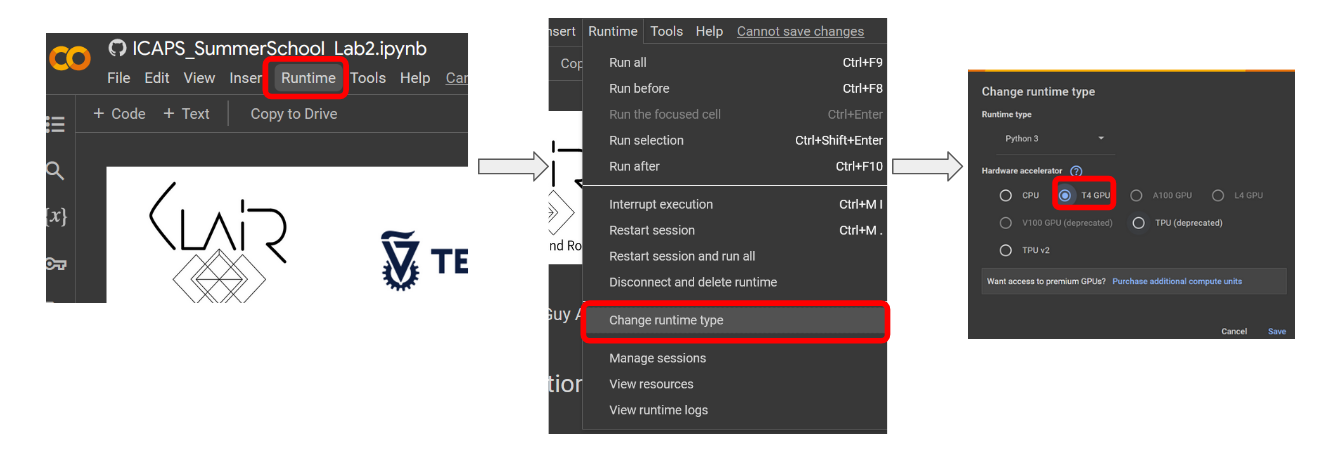

In [ ]:
#@title mount your Google Drive
import os
connect_drive = False #@param {type: "boolean"}
if connect_drive:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # set up mount symlink
  DRIVE_PATH = '/content/gdrive/My\ Drive/cs236203_s24'
  DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
  if not os.path.exists(DRIVE_PYTHON_PATH):
    %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs236203_s24'
if not os.path.exists(SYM_PATH) and connect_drive:
  !ln -s $DRIVE_PATH $SYM_PATH




In [ ]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

from IPython.display import clear_output

!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1
!pip install gymnasium

clear_output()

In [ ]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
import numpy as np

from collections import deque
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch import distributions

# Gym
import gymnasium as gym




### Check if we have a GPU

- Let's check if we have a GPU
- If it's the case you should see `device:cuda0`

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

# <img src="https://img.icons8.com/?size=50&id=42948&format=png&color=000000" style="height:30px;display:inline"> The CartPole-v1 Environment



The [CartPole-v1 environment](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) is a classic control task in reinforcement learning. It is designed to test the basic capabilities of an RL algorithm in a simple yet challenging setting. Here’s a detailed description of the environment:

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart, and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The agent must learn to push the cart left or right **to keep the pole balanced and prevent it from falling over**.


<img src='https://gymnasium.farama.org/_images/cart_pole.gif' width=800/>

## <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 1: Getting Familiar with the CartPole Environment



<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/task_sign.png?raw=true' width=800/>

In this task, you will explore the CartPole-v1 environment. Your objective is to understand the basic operations of this environment, such as resetting the environment, taking actions, and observing the outcomes.

Questions:
- What are the dimensions of the state space?
- What are the possible actions in the action space?
- What triggers the termination of an episode in CartPole-v1?

In [ ]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)


#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline">  Solution



In [ ]:
# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

The state space of the CartPole-v1 environment is represented by a 4-dimensional vector:

1. **Cart Position**: The position of the cart along the track.
2. **Cart Velocity**: The velocity of the cart.
3. **Pole Angle**: The angle of the pole with respect to the vertical position.
4. **Pole Angular Velocity**: The rate of change of the pole's angle.

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

The action space is **discrete**, consisting of two possible actions:

1. **Push Left**: Apply a force to the left.
2. **Push Right**: Apply a force to the right.

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

The agent receives a reward 💰 of +1 for every timestep that the pole remains upright. The goal is to maximize the total reward over an episode.

An episode ends if any of the following conditions are met:

- The pole angle exceeds ±12 degrees.
- The cart position exceeds ±2.4 units from the center.
- The episode length exceeds 500 timesteps.

## <img src="https://img.icons8.com/?size=50&id=66365&format=png&color=000000" style="height:30px;display:inline"> Why do we use a simple environment like CartPole-v1?
As explained in [Reinforcement Learning Tips and Tricks](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html), when you implement your agent from scratch you need **to be sure that it works correctly and find bugs with easy environments before going deeper**. Since finding bugs will be much easier in simple environments.

> Try to have some “sign of life” on toy problems


> Validate the implementation by making it run on harder and harder envs (you can compare results against the RL zoo). You usually need to run hyperparameter optimization for that step.

# <img src="https://img.icons8.com/?size=50&id=104291&format=png&color=000000" style="height:30px;display:inline"> Policy-Based Methods



The main goal of reinforcement learning is to find the optimal policy $\pi^*$ that will maximize the expected cumulative reward. This is based on the [reward hypothesis](https://arxiv.org/pdf/2212.10420): all goals can be described as the maximization of the expected cumulative reward.

In reinforcement learning, policy-based methods are a class of algorithms that directly optimize the policy $\pi_{\theta}(a|s)$, where $\theta$ represents the parameters of the policy, $s$ is the state, and $a$ is the action. These methods differ from value-based methods, which focus on learning a value function and deriving the policy from it. Policy-based methods aim to directly find the optimal policy by maximizing the expected return.

### <img src="https://img.icons8.com/?size=50&id=43167&format=png&color=000000" style="height:30px;display:inline"> Policies



The following cells are more advanced and contain mathematical and practical information on how to represent the policy distribution using PyTorch.

A policy is a rule used by an agent to decide what actions to take. It can be deterministic, in which case it is usually denoted by $\mu$:

$$
a_t = \mu(s_t)
$$

or it may be stochastic, in which case it is usually denoted by $\pi$:

$$
a_t \sim \pi(\cdot | s_t)
$$


In deep RL, we deal with parameterized policies: policies whose outputs are computable functions that depend on a set of parameters (e.g., the weights and biases of a neural network) which we can adjust to change the behavior via some optimization algorithm.

We often denote the parameters of such a policy by $\theta$ or $\phi$, and then write this as a subscript on the policy symbol to highlight the connection:

$$
a_t = \mu_{\theta}(s_t) \\
a_t \sim \pi_{\theta}(\cdot | s_t)
$$

#### Deterministic Policies

Example: Deterministic Policies. Here is a code snippet for building a simple deterministic policy for a continuous action space in PyTorch, using the `torch.nn` package:

In [ ]:
import torch
import torch.nn as nn

obs_dim = 4  # example observation dimension
act_dim = 1  # example action dimension

pi_net = nn.Sequential(
    nn.Linear(obs_dim, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, act_dim)
)

obs = torch.randn(10, obs_dim)  # example batch of observations
obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
actions = pi_net(obs_tensor)
actions

This builds a multi-layer perceptron (MLP) network with two hidden layers of size 64 and `tanh` activation functions. If `obs` is a Numpy array containing a batch of observations, `pi_net` can be used to obtain a batch of actions as shown above.

#### Stochastic Policies

The two most common kinds of stochastic policies in deep RL are categorical policies and diagonal Gaussian policies.

- **Categorical Policies**: Used in discrete action spaces.
- **Diagonal Gaussian Policies**: Used in continuous action spaces.

Two key computations are centrally important for using and training stochastic policies: sampling actions from the policy and computing log likelihoods of particular actions, $\log \pi_{\theta}(a|s)$.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/stochastic_policy.png' width=700/>

#### Categorical Policies

Here is a simple example of how to use categorical policies in PyTorch:


In [ ]:

import torch.nn.functional as F
from torch.distributions import Categorical

# Define the policy network
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Initialize the policy
s_size = 4  # example state size (e.g., for CartPole)
a_size = 2  # example action size (e.g., left or right)
h_size = 128  # hidden layer size
policy = Policy(s_size, a_size, h_size)

# Example state input
state = torch.tensor([0.0, 0.1, -0.1, 0.2])

# Forward pass through the policy to get action probabilities
probs = policy(state.unsqueeze(0))  # add batch dimension

# Create a categorical distribution and sample an action
m = Categorical(probs)
action = m.sample()

# Calculate the log probability of the sampled action
log_prob = m.log_prob(action)

# We compute the log probability of the sampled action, which is useful for calculating the policy gradient during training.

# Print the results
print("Action probabilities:", probs)
print("Sampled action:", action.item())
print("Log probability of the action:", log_prob.item())

#### Diagonal Gaussian Policies

A multivariate Gaussian distribution (or multivariate normal distribution, if you prefer) is described by a mean vector, $\mu$, and a covariance matrix, $\Sigma$. A diagonal Gaussian distribution is a special case where the covariance matrix only has entries on the diagonal. As a result, we can represent it by a vector.

A diagonal Gaussian policy always has a neural network that maps from observations to mean actions, $\mu_{\theta}(s)$. There are two different ways that the covariance matrix is typically represented:

1. **Fixed Log Standard Deviations**: There is a single vector of log standard deviations, $\log \sigma$, which is not a function of state: the $\log \sigma$ are standalone parameters.
2. **State-Dependent Log Standard Deviations**: There is a neural network that maps from states to log standard deviations, $\log \sigma_{\theta}(s)$. It may optionally share some layers with the mean network.

Note that in both cases we output log standard deviations instead of standard deviations directly. This is because log stds are free to take on any values in $(-\infty, \infty)$, while stds must be nonnegative. It’s easier to train parameters if you don’t have to enforce those kinds of constraints. The standard deviations can be obtained immediately from the log standard deviations by exponentiating them, so we do not lose anything by representing them this way.

Standard frameworks have built-in ways to generate the noise vectors, such as [`torch.normal`](https://pytorch.org/docs/stable/torch.html#torch.normal) . Alternatively, you can build distribution objects, e.g., through [`torch.distributions.Normal`](https://pytorch.org/docs/stable/distributions.html#normal) , and use them to generate samples. (The advantage of the latter approach is that those objects can also calculate log-likelihoods for you.)



In [ ]:
from torch.distributions import Normal

# Define the policy network
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.log_std = nn.Parameter(torch.zeros(a_size))  # Log standard deviation

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc2(x)
        std = torch.exp(self.log_std)  # Standard deviation
        return mu, std

# Initialize the policy
s_size = 4  # example state size (e.g., for continuous control task)
a_size = 2  # example action size (e.g., 2D action space)
h_size = 128  # hidden layer size
policy = Policy(s_size, a_size, h_size)

# Example state input
state = torch.tensor([0.0, 0.1, -0.1, 0.2])

# Forward pass through the policy to get mean and standard deviation of action distribution
mu, std = policy(state.unsqueeze(0))  # add batch dimension

# Create a normal distribution and sample an action
m = Normal(mu, std)
action = m.sample()

# Calculate the log probability of the sampled action
log_prob = m.log_prob(action).sum(dim=-1)

# Print the results
print("Mean of action distribution:", mu)
print("Standard deviation of action distribution:", std)
print("Sampled action:", action)
print("Log probability of the action:", log_prob)

## <img src="https://img.icons8.com/?size=50&id=65842&format=png&color=000000" style="height:30px;display:inline"> Simplest Policy Gradient



Policy gradient methods are a subset of policy-based methods that use the gradient of the expected return with respect to the policy parameters to iteratively improve the policy.

Our goal with policy-gradient is to **control the probability distribution of actions** by tuning the policy such that **good actions (that maximize the return) are sampled more frequently in the future**. Each time the agent interacts with the environment, we tweak the parameters such that good actions will be sampled more likely in the future.

**But how are we going to optimize the weights using the expected return?**

The idea is to let the agent interact with the environment during an episode. If the agent wins the episode, we consider that each action taken was beneficial and should be more likely sampled in the future, as they led to a win. Conversely, if the agent loses, the actions taken should be less likely sampled.

For each state-action pair, we want to adjust the policy to increase the probability $P(a|s)$ of taking an action $a$ in a state $s$ if it led to a positive outcome, and decrease it if it led to a negative outcome. This approach ensures that actions leading to higher returns become more probable, guiding the agent toward optimal behavior over time.

#### Optimizing the Policy

In this section, we will derive the simplest form of the policy gradient for a stochastic, parameterized policy $\pi_{\theta}$. Our aim is to maximize the expected cumulative return $J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}[R(\tau)]$,  where $R(\tau)$ represents the finite-horizon undiscounted return. The derivation for the infinite-horizon discounted return setting is almost identical.

**Our objective then is to maximize the expected cumulative reward by finding the
$θ$ that will output the best action probability.**

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/probability.png' width=800/>

Policy-gradient is an optimization problem: we want to find the values of $\theta$ that maximize our objective function $J(\theta)$, so we need to use gradient ascent. It’s the inverse of gradient descent since it gives the direction of the steepest increase of $J(\theta)$.

(If you need a refresher on the difference between gradient descent and gradient ascent, check [this](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21) and [this](https://www.baeldung.com/cs/gradient-descent-vs-ascent)).


**To optimize the policy, we use gradient ascent**:

$$
\theta_{k+1} = \theta_k + \alpha \left. \nabla_{\theta} J(\pi_{\theta}) \right|_{\theta_k}
$$

The gradient of policy performance, $\nabla_{\theta} J(\pi_{\theta})$, is known as the policy gradient. Algorithms that optimize the policy in this way are called policy gradient algorithms.

We can repeatedly apply this update in the hopes that $\theta$ converges to the value that maximizes $J(\theta)$.

However, there are two problems with computing the derivative of $J(\theta)$:

1. **Computational Complexity**: We can’t calculate the true gradient of the objective function since it requires calculating the probability of each possible trajectory, which is computationally super expensive. Instead, we calculate a gradient estimation with a sample-based estimate by collecting some trajectories.

2. **Non-differentiable State Distribution**: To differentiate this objective function, we need to differentiate the state distribution, called the Markov Decision Process dynamics. This distribution is attached to the environment and gives us the probability of the environment transitioning to the next state, given the current state and the action taken by the agent. The problem is that we can’t differentiate it because **we might not have explicit knowledge of it.**

#### <img src="https://img.icons8.com/?size=50&id=43167&format=png&color=000000" style="height:30px;display:inline"> Deriving the Policy Gradient

The following cells contain a mathematical proof of the expression for the objective function, which you will see in the next cells. This proof is central to the theory of Policy Gradient methods. We encourage you to go through it slowly and carefully. If you have any questions, please feel free to ask us for clarification. Understanding this proof will provide you with a solid foundation for comprehending the theoretical underpinnings of Policy Gradient algorithms.

To use this algorithm, we need an expression for the policy gradient that we can numerically compute. This involves two steps:
1. Deriving the analytical gradient of policy performance, which is an expected value.
2. Forming a sample estimate of that expected value using data from agent-environment interactions.

We will start by laying out some useful facts for deriving the analytical gradient.



**1. Probability of a Trajectory**

The probability of a trajectory $\tau = (s_0, a_0, \ldots, s_{T+1})$ given that actions come from $\pi_{\theta}$ is:

$$
P(\tau|\theta) = \rho_0 (s_0) \prod_{t=0}^{T} P(s_{t+1}|s_t, a_t) \pi_{\theta}(a_t |s_t)
$$

**2. The Log-Derivative Trick**

The log-derivative trick is based on the rule from calculus that the derivative of $\log x$ with respect to $x$ is $1/x$. Rearranging and combining this with the chain rule, we get:

$$
\nabla_{\theta} P(\tau | \theta) = P(\tau | \theta) \nabla_{\theta} \log P(\tau | \theta)
$$

**3. Log-Probability of a Trajectory**

The log-probability of a trajectory is:

$$
\log P(\tau|\theta) = \log \rho_0 (s_0) + \sum_{t=0}^{T} \left( \log P(s_{t+1}|s_t, a_t) + \log \pi_{\theta}(a_t |s_t) \right)
$$


**4. Gradients of Environment Functions**

The environment has no dependence on $\theta$, so gradients of $\rho_0(s_0)$, $P(s_{t+1}|s_t, a_t)$, and $R(\tau)$ are zero.

**5. Gradient of the Log-Probability of a Trajectory**

The gradient of the log-probability of a trajectory is:

$$
\nabla_{\theta} \log P(\tau | \theta) = \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t)
$$

Putting it all together, we can derive the basic policy gradient:

$$
\begin{align*}
\nabla_{\theta} J(\pi_{\theta}) &= \nabla_{\theta} \mathbb{E}_{\tau \sim \pi_{\theta}}[R(\tau)] \\
&= \nabla_{\theta} \int_{\tau} P(\tau|\theta) R(\tau) \quad \text{(Expand expectation)} \\
&= \int_{\tau} \nabla_{\theta} P(\tau|\theta) R(\tau) \quad \text{(Bring gradient under integral)} \\
&= \int_{\tau} P(\tau|\theta) \nabla_{\theta} \log P(\tau|\theta) R(\tau) \quad \text{(Log-derivative trick)} \\
&= \mathbb{E}_{\tau \sim \pi_{\theta}}[\nabla_{\theta} \log P(\tau|\theta) R(\tau)] \quad \text{(Return to expectation form)} \\
\therefore \nabla_{\theta} J(\pi_{\theta}) &= \mathbb{E}_{\tau \sim \pi_{\theta}} \left[ \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau) \right]
\end{align*}
$$

This expectation can be estimated with a sample mean. If we collect a set of trajectories $\mathcal{D} = \{\tau_i\}_{i=1,...,N}$, where each trajectory is obtained by letting the agent act in the environment **using the policy $\pi_{\theta}$**, the policy gradient can be estimated with:

$$
\hat{g} = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau)
$$

where $|\mathcal{D}|$ is the number of trajectories in $\mathcal{D}$ (here, $N$).

This expression is the simplest version of the computable policy gradient. Assuming we have represented our policy in a way that allows us to calculate $\nabla_{\theta} \log \pi_{\theta}(a|s)$, and if we can run the policy in the environment to collect the trajectory dataset, we can compute the policy gradient and take an update step.

# <img src="https://img.icons8.com/?size=50&id=qjEfYyGK_vq-&format=png&color=000000" style="height:30px;display:inline"> The REINFORCE Algorithm (Monte Carlo policy-gradient)




The REINFORCE algorithm, also called Monte Carlo policy-gradient, is a policy-gradient algorithm that uses an estimated return from **an entire episode to update** the policy parameter $\theta$.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/policy_based.png' width=800/>

#### Why is the REINFORCE Algorithm Also Called Monte Carlo Policy Gradient?

The REINFORCE algorithm is often referred to as Monte Carlo Policy Gradient because it uses Monte Carlo methods to estimate the gradients of the policy. Specifically, it relies on complete episode rollouts to compute the return (total accumulated reward) from each state-action pair. These returns are then used to update the policy parameters. The term "Monte Carlo" signifies the use of random sampling to estimate these returns, capturing the essence of the algorithm's approach to learning optimal policies through trial and error.


### REINFORCE Algorithm Steps

1. **Collect an Episode**: Use the policy $\pi_{\theta}$ to collect an episode $\tau$.
2. **Estimate the Gradient**: Use the episode to estimate the gradient $\hat{g} = \nabla_{\theta} J(\theta)$.
3. **Update the Policy Weights**: Update the weights of the policy:
   $$
   \theta \leftarrow \theta + \alpha \hat{g}
   $$

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/policy_gradient_one.png' width=800/>

We can interpret the policy gradient update as follows:

- **$\nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t)$**: This term represents the direction of the steepest increase in the (log) probability of selecting action $a_t$ from state $s_t$. It indicates how we should adjust the weights of the policy to increase or decrease the log probability of selecting action $a_t$ at state $s_t$.

- **$R(\tau)$**: This is the scoring function. If the return is high, it will increase the probabilities of the (state, action) combinations. Conversely, if the return is low, it will decrease the probabilities of the (state, action) combinations.

In essence, the policy gradient update modifies the policy parameters $\theta$ to favor actions that lead to higher returns and disfavor actions that lead to lower returns. This approach ensures that the agent learns to take actions that maximize the expected cumulative reward.

### Let's build the Reinforce Architecture


<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/task_sign.png?raw=true' width=800/>

### <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 2: Implement the select_action function

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # Apply softmax activation to get action probabilities

    def select_action(self, state):
        # TODO: Implement this function
        # Convert the state to a torch tensor, add a batch dimension, and move it to the correct device
        # Perform a forward pass to get action probabilities, and move them to the CPU
        # Create a categorical distribution based on the probabilities
        # Select an action using the categorical distribution
        # Return the selected action and its log probability
        pass

#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def select_action(self, state):
        state = state[0] if type(state) is tuple else state # Gymnasium return (state, info) tuple.
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Convert state to a torch tensor, add batch dimension, and move to the correct device
        probs = self.forward(state).cpu()  # Perform a forward pass to get action probabilities, and move them to the CPU
        m = Categorical(probs)  # Create a categorical distribution based on the probabilities
        action = m.sample()  # Sample the action
        return action.item(), m.log_prob(action) # Return the selected action and its log probability

In [ ]:
debug_policy = Policy(s_size, a_size, 64).to(device)

debug_policy.select_action(env.reset())


### <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 3: Build the Reinforce Training Algorithm
This is the Reinforce algorithm pseudocode:

1. **Collect an Episode**: Use the policy $\pi_{\theta}$ to collect an episode $\tau$.
2. **Estimate the Gradient**: Use the episode to estimate the gradient $\hat{g} = \nabla_{\theta} J(\theta)$.
3. **Update the Policy Weights**: Update the weights of the policy:
   $$
   \theta \leftarrow \theta + \alpha \hat{g}
   $$
  

In [ ]:
def reinforce(policy, optimizer, env, n_training_episodes, max_t, gamma, print_every):
    scores = []  # List to store scores from each episode
    scores_deque = deque(maxlen=100)  # Deque to store the last 100 scores

    for i_episode in range(1, n_training_episodes + 1):
        state = env.reset()  # Reset the environment and get the initial state
        log_probs = []  # List to store log probabilities of actions taken
        rewards = []  # List to store rewards obtained

        for t in range(max_t):
            action, log_prob = policy.select_action(state)  # Select action using the policy
            state, reward, trunced, terminated,  _ = env.step(action)  # Take a step in the environment
            log_probs.append(log_prob)  # Store the log probability of the action
            rewards.append(reward)  # Store the reward obtained

            if trunced or terminated:
                break  # Exit loop if the episode is done

        scores_deque.append(sum(rewards))  # Append total reward for this episode to the deque
        scores.append(sum(rewards))  # Append total reward for this episode to the list

        # Compute the cumulative reward (returns)

        #TODO
        R = _______  # Total reward for the episode
        policy_loss = []  # List to store policy loss values

        # Compute policy loss
        for log_prob in log_probs:
            policy_loss.append(-log_prob * R)  # Append the negative log probability scaled by the total reward

        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        # TODO
        policy_loss = _______  # Sum up all policy losses
        policy_loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the policy using the optimizer

        # Print average score every `print_every` episodes
        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque)}')

    return scores

#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [ ]:
def reinforce(policy, optimizer, env, n_training_episodes, max_t, gamma, print_every):
    scores = []  # List to store scores from each episode
    scores_deque = deque(maxlen=100)  # Deque to store the last 100 scores

    for i_episode in range(1, n_training_episodes + 1):
        state = env.reset()  # Reset the environment and get the initial state
        log_probs = []  # List to store log probabilities of actions taken
        rewards = []  # List to store rewards obtained

        for t in range(max_t):
            action, log_prob = policy.select_action(state)  # Select action using the policy
            state, reward, trunced, terminated,  _ = env.step(action)  # Take a step in the environment
            log_probs.append(log_prob)  # Store the log probability of the action
            rewards.append(reward)  # Store the reward obtained

            if trunced or terminated:
                break  # Exit loop if the episode is done

        scores_deque.append(sum(rewards))  # Append total reward for this episode to the deque
        scores.append(sum(rewards))  # Append total reward for this episode to the list

        # Compute the cumulative reward (returns)
        R = sum(rewards)  # Total reward for the episode
        policy_loss = []  # List to store policy loss values

        # Compute policy loss
        for log_prob in log_probs:
            policy_loss.append(-log_prob * R)  # Append the negative log probability scaled by the total reward

        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        policy_loss = torch.cat(policy_loss).sum()  # Sum up all policy losses
        policy_loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the policy using the optimizer

        # Print average score every `print_every` episodes
        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque)}')

    return scores

## <img src="https://img.icons8.com/?size=50&id=104328&format=png&color=000000" style="height:50px;display:inline"> Training

- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters.

In [ ]:
cartpole_hyperparameters = {
    "h_size": 128,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.99,
    "lr": 1e-3,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
# Create policy and place it to the device
policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)

optimizer = optim.Adam(policy.parameters(), lr=cartpole_hyperparameters["lr"])

n_training_episodes = cartpole_hyperparameters["n_training_episodes"]
max_t = cartpole_hyperparameters["max_t"]
gamma = cartpole_hyperparameters["gamma"]

In [ ]:
print_every = 100

scores = reinforce(policy, optimizer, env, n_training_episodes, max_t, gamma, print_every)

### <img src="https://img.icons8.com/?size=50&id=46767&format=png&color=000000" style="height:50px;display:inline"> Understanding the "Loss" Function in Policy Gradients

```python
# make loss function whose gradient, for the right data, is policy gradient
def compute_loss(obs, act, weights):
    logp = get_policy(obs).log_prob(act)
    return -(logp * weights).mean()


In this block, we build a “loss” function for the policy gradient algorithm. When the right data is plugged in, the gradient of this loss is equal to the policy gradient. The right data means a set of (state, action, weight) tuples collected while acting according to the current policy, where the weight for a state-action pair is the return from the episode to which it belongs.



Even though we describe this as a loss function, it is not a loss function in the typical sense from supervised learning. There are two main differences from standard loss functions:

1. **Data Distribution Depends on the Parameters**: A loss function is usually defined on a fixed data distribution which is independent of the parameters we aim to optimize. Not so here, where the data must be sampled on the most recent policy.

2. **It Doesn’t Measure Performance**: A loss function usually evaluates the performance metric that we care about. Here, we care about the expected return, $J(\pi_{\theta})$, but our “loss” function does not approximate this at all, even in expectation. This “loss” function is only useful to us because, when evaluated at the current parameters, with data generated by the current parameters, it has the negative gradient of performance.

But after that first step of gradient descent, there is no more connection to performance. This means that minimizing this “loss” function, for a given batch of data, has no guarantee whatsoever of improving expected return. You can send this loss to $-\infty$ and policy performance could crater; in fact, it usually will. Sometimes a deep RL researcher might describe this outcome as the policy “overfitting” to a batch of data. This is descriptive, but should not be taken literally because it does not refer to generalization error.

We raise this point because it is common for ML practitioners to interpret a loss function as a useful signal during training—“if the loss goes down, all is well.” In policy gradients, this intuition is wrong, and you should only care about average return. The loss function means nothing.

## <img src="https://img.icons8.com/?size=50&id=55069&format=png&color=000000" style="height:50px;display:inline"> Evaluating the policy


In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state, _ = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.select_action(state)
      new_state, reward, terminated, truncated, _  = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [ ]:
eval_env = gym.make(env_id)

mean_reward, std_reward = evaluate_agent(eval_env,
               cartpole_hyperparameters["max_t"],
               cartpole_hyperparameters["n_evaluation_episodes"],
               policy)
mean_reward, std_reward

Our results are far from optimal, with the maximum reward being 500. This indicates that there are significant issues with our algorithm. In the upcoming sections, we will discuss these problems in detail and explore potential solutions to address them.

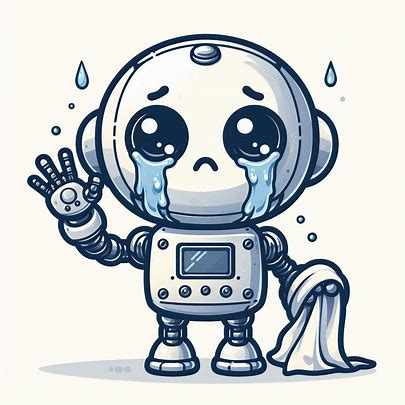

# <img src="https://img.icons8.com/?size=50&id=yg0Xl3Bazd07&format=png&color=000000" style="height:50px;display:inline"> Challenges in Policy Gradient


Policy gradient methods, despite their conceptual simplicity and direct approach to optimizing policies, face several significant challenges that can hinder their practical application.


In [ ]:
# Plotting the results
def plot_rewards(reward_history):
    plt.figure(figsize=(12, 6))
    plt.plot(reward_history, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Algorithm on CartPole')
    plt.legend()
    plt.show()

plot_rewards(scores)


As observed in the plot, our algorithm suffers from very high variance, which prevents it from converging effectively. The necessity to sample entire trajectories on-policy before each gradient update is inherently slow. The high variance in updates exacerbates the inefficiency of the optimization process, leading to the need for more sampling and more updates, creating a vicious cycle that hinders progress.


### <img src="https://img.icons8.com/?size=50&id=46850&format=png&color=000000" style="height:50px;display:inline"> High Variance



The updates made by the policy gradient are **very high variance**. To get a sense for why this is, first considering that in RL we're dealing with highly general problems such as teaching a car to navigate through an unpredictable environment or programming an agent to perform well across a diverse set of video games.

Therefore, when we're sampling multiple trajectories from our untrained policy we're bound to observe highly variable behaviors. Without any a priori model of the system we're seeking to optimize, **we begin with a policy whose distribution of actions over a given state is effectively uniform**. Of course, as we train the model we hope to shape the probability density so that it's unimodal on a single action, or possibly multimodal over a few successful actions that can be taken in that state. However, **acquiring this knowledge requires our model to observe the outcomes of many different actions taken in many different states**. This is made exponentially worse in continuous action or state spaces as visiting even close to every state-action pair is computationally intractable.

 Due to the fact that we're using Monte Carlo estimates in policy gradient, **we trade off between computational feasibility and gradient accuracy**. It's a fine line to walk, which is why variance reduction techniques can potentially yield huge payoffs.


Another way to think about the variance introduced into the policy gradient update is as follows: at each time step in your trajectory you're observing some stochastic event. Each such event has some noise, and the accumulation of even a small amount of noise across a number of time steps results in a high variance outcome. Yet, understanding this allows us to suggest some ways to alter policy gradient so that the variance might ultimately be reduced.

### <img src="https://img.icons8.com/?size=50&id=46522&format=png&color=000000" style="height:50px;display:inline"> Sample Inefficency



In order to get anything useful out of policy gradient, **it's necessary to sample from your policy and observe the resultant reward infinte number of times.**

Because we're sampling directly from the policy we're optimizing, we say that policy gradient is an **on-policy** algorithm. If you take a look at the formula for the gradient update, we're calculating an expectation and we're doing that in the Monte Carlo way, by averaging over a number of trial runs. Within that, we have to sum over all the steps in a single trajectory which itself **could be frustratingly expensive to run depending on the nature of the environment** you're working with. So we're iterating sums over sums, and the result is that we incur hugely expensive computational costs in order to acquire anything useful. This works fine in the realms where policy gradient has been successfully applied. If all you're interested in is training your computer to play Atari games, then policy gradient might not be a terrible choice. However, imagine using this process in anything remotely resembling a real-world task, like training a robotic arm to perform open-heart surgery. However, sample inefficiency is not a problem that's unique to policy gradient methods by any means. It's an issue that plagues many different RL algorithms, and addressing this is key to generating a model that's useful in the real world.

# <img src="https://img.icons8.com/?size=50&id=42831&format=png&color=000000" style="height:50px;display:inline"> Reducing Variance in Policy Gradients


To make policy gradients practical for reinforcement learning, we need to address the high variance in the gradient estimates. Two primary techniques help reduce this variance: exploiting causality and introducing a baseline.




## <img src="https://img.icons8.com/?size=50&id=4ol5HxFd7R75&format=png&color=000000" style="height:50px;display:inline"> Modifying the Policy Gradient Using Causality




**Causality** states that the policy at time $ t' $ cannot affect the reward at another time step $ t $ if $ t $ is less than $ t' $. In other words, actions in the present cannot change rewards received in the past. This is always true in our universe where time flows forward.


<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/tut04_Don%E2%80%99t_Let_the_Past_Distract_You.png?raw=true' width=800/>

Let's examine our most recent expression for the policy gradient:

$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim P_{\theta}(\tau)} \left[ \sum_{t=1}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) R(\tau) \right] $

Taking a step with this gradient pushes up the log-probabilities of each action in proportion to $R(\tau)$, the sum of all rewards ever obtained. But this doesn’t make much sense.

Agents should really only reinforce actions **on the basis of their consequences**. Rewards obtained before taking an action have no bearing on how good that action was: only rewards that come after.




It turns out that this intuition shows up in the [math](https://ai.stackexchange.com/questions/9614/why-does-the-reward-to-go-trick-in-policy-gradient-methods-work), and we can show that the policy gradient can also be expressed by

$ \nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim P_{\theta}(\tau)} \left[ \sum_{t=1}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) \sum_{t'=t}^{T} R(s_{t'}, a_{t'}) \right] $

In this form, actions are only reinforced based on rewards obtained after they are taken.

This new sum, $ \sum_{t'=t}^{T} R(s_{t'}, a_{t'}) $, is known as the **reward-to-go**. It only considers future rewards, which the current action can influence.

#### But how is this better?

A key problem with policy gradients is how many sample trajectories are needed to get a low-variance sample estimate for them. The formula we started with included terms for reinforcing actions proportional to past rewards, **all of which had zero mean, but nonzero variance**: as a result, they would just add noise to sample estimates of the policy gradient. By removing them, we reduce the number of sample trajectories needed.

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/task_sign.png?raw=true' width=800/>

### <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 4: Implementing Reward-to-Go

In this task, you will modify the REINFORCE algorithm to implement the reward-to-go strategy

In [ ]:
def reinforce(policy, optimizer, env, n_training_episodes, max_t, gamma, print_every):
    scores = []  # List to store scores from each episode
    scores_deque = deque(maxlen=100)  # Deque to store the last 100 scores

    for i_episode in range(1, n_training_episodes + 1):
        state = env.reset()  # Reset the environment and get the initial state
        log_probs = []  # List to store log probabilities of actions taken
        rewards = []  # List to store rewards obtained

        for t in range(max_t):
            action, log_prob = policy.select_action(state)  # Select action using the policy
            state, reward, trunced, terminated, _ = env.step(action)  # Take a step in the environment
            log_probs.append(log_prob)  # Store the log probability of the action
            rewards.append(reward)  # Store the reward obtained

            if trunced or terminated:
                break  # Exit loop if the episode is done

        scores_deque.append(sum(rewards))  # Append total reward for this episode to the deque
        scores.append(sum(rewards))  # Append total reward for this episode to the list

        # Compute the reward-to-go (returns)
        R = 0
        policy_loss = []  # List to store policy loss values
        returns = []  # List to store the returns (cumulative rewards)


  	    # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        #TODO: implement the reward-to-go


        # Compute policy loss
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)  # Append the negative log probability scaled by the return

        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        policy_loss = torch.cat(policy_loss).sum()  # Sum up all policy losses
        policy_loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the policy using the optimizer

        # Print average score every `print_every` episodes
        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque)}')

    return scores



#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [ ]:
def reinforce(policy, optimizer, env, n_training_episodes, max_t, gamma, print_every):
    scores = []  # List to store scores from each episode
    scores_deque = deque(maxlen=100)  # Deque to store the last 100 scores

    for i_episode in range(1, n_training_episodes + 1):
        state = env.reset()  # Reset the environment and get the initial state
        log_probs = []  # List to store log probabilities of actions taken
        rewards = []  # List to store rewards obtained

        for t in range(max_t):
            action, log_prob = policy.select_action(state)  # Select action using the policy
            state, reward, trunced, terminated, _ = env.step(action)  # Take a step in the environment
            log_probs.append(log_prob)  # Store the log probability of the action
            rewards.append(reward)  # Store the reward obtained

            if trunced or terminated:
                break  # Exit loop if the episode is done

        scores_deque.append(sum(rewards))  # Append total reward for this episode to the deque
        scores.append(sum(rewards))  # Append total reward for this episode to the list

        # Compute the reward-to-go (returns)
        R = 0
        policy_loss = []  # List to store policy loss values
        returns = []  # List to store the returns (cumulative rewards)


  	    # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        # The following loop implements the reward-to-go
        for r in rewards[::-1]: # Instead of calculating the total reward for the entire episode, we now calculate the cumulative future rewards from each time step.
            R = r + gamma * R  # Compute the return
            returns.insert(0, R)  # Insert return at the beginning of the list

        returns = torch.tensor(returns)  # Convert returns to a tensor
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)  # Normalize returns

        # Compute policy loss
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)  # Append the negative log probability scaled by the return

        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        policy_loss = torch.cat(policy_loss).sum()  # Sum up all policy losses
        policy_loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the policy using the optimizer

        # Print average score every `print_every` episodes
        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque)}')

    return scores


### <img src="https://img.icons8.com/?size=50&id=55069&format=png&color=000000" style="height:50px;display:inline"> Evaluating the policy


Let's evaluate the results after implementing reward-to-go in our REINFORCE algorithm.

In [ ]:
policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)

optimizer = optim.Adam(policy.parameters(), lr=cartpole_hyperparameters["lr"])

n_training_episodes = cartpole_hyperparameters["n_training_episodes"]
max_t = cartpole_hyperparameters["max_t"]
gamma = cartpole_hyperparameters["gamma"]

In [ ]:
print_every = 100

scores = reinforce(policy, optimizer, env, n_training_episodes, max_t, gamma, print_every)

plot_rewards(scores)

In [ ]:
mean_reward, std_reward = evaluate_agent(eval_env,
               cartpole_hyperparameters["max_t"],
               cartpole_hyperparameters["n_evaluation_episodes"],
               policy)
mean_reward, std_reward

As you can see, our results have significantly improved. However, the graph still shows some unstable learning, which hinders complete convergence. This instability indicates that there is room for further improvement. In the next tutorials, we will explore additional methods to enhance the learning process and achieve more stable convergence.

# <img src="https://img.icons8.com/?size=100&id=46509&format=png&color=000000" style="height:50px;display:inline"> Conclusion
---

In this tutorial, we explored the fundamentals of policy gradient methods in reinforcement learning. We started with an introduction to policy gradients, discussing the core idea of optimizing policies through gradient ascent. We derived the simplest form of the policy gradient and implemented the REINFORCE algorithm, highlighting the issues of high variance in gradient estimates.

We then introduced the concept of "Reward-to-Go" as a technique to reduce variance by considering only future rewards that actions can influence. This method helps stabilize and improve the efficiency of the learning process.

While "Reward-to-Go" is an effective approach, there are additional methods to further address high variance, such as using baselines. These techniques help to normalize rewards and reduce the variance of gradient estimates even further. In the next tutorials, we will delve into these advanced methods and explore how they can enhance the performance of policy gradient algorithms.






# <img src="https://img.icons8.com/dusk/64/000000/plus-2-math.png" style="height:50px;display:inline"> Further Reading
---


* [Introduction to Policy Gradient Methods](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#id16) - An accessible overview of policy gradient methods, explaining the foundational concepts and how they are applied in reinforcement learning.

#### Relevant Papers

* [Policy Gradient Methods for Reinforcement Learning with Function Approximation, Sutton et al. 2000](https://www.cs.toronto.edu/~vmnih/docs/sutton-barto-2018.pdf) - A timeless classic in reinforcement learning theory, detailing the foundational work that led to modern policy gradients.
* [Optimizing Expectations: From Deep Reinforcement Learning to Stochastic Computation Graphs, Schulman 2016(a)](https://arxiv.org/abs/1504.07605) - Chapter 2 provides a lucid introduction to the theory of policy gradient algorithms, including pseudocode.
* [Benchmarking Deep Reinforcement Learning for Continuous Control, Duan et al. 2016](https://arxiv.org/abs/1604.06778) - A benchmark paper comparing vanilla policy gradient with other deep RL algorithms using neural network policies and Adam as the optimizer.
* [High Dimensional Continuous Control Using Generalized Advantage Estimation, Schulman et al. 2016(b)](https://arxiv.org/abs/1506.02438) - This paper introduces Generalized Advantage Estimation (GAE), which our implementation of VPG uses for computing the policy gradient.

#### Additional Resources

* [PG is All You Need](https://github.com/MrSyee/pg-is-all-you-need) - A comprehensive repository providing implementations and explanations of various policy gradient algorithms.
* [RL: Policy Gradients Explained](https://jonathan-hui.medium.com/rl-policy-gradients-explained-9b13b688b146) - A detailed explanation of policy gradients, including theoretical insights and practical tips.






# <img src="https://img.icons8.com/?size=100&id=46756&format=png&color=000000" style="height:50px;display:inline"> Credits
---
* Examples and code snippets were taken from <a href="https://huggingface.co/learn/deep-rl-course/unit4/introduction"> Hugging Face Deep RL Course </a>
* Examples and explanations were taken from <a href="https://rail.eecs.berkeley.edu/deeprlcourse/">CS285 - Deep Reinforcement Learning Course at UC Berkeley</a>
* Icons from <a href="https://icons8.com/">Icons8.com